In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from collections import defaultdict

In [2]:
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = '../Data Sets/'
path_dic = {'B': 'business_s.csv', 'R':'review_text.csv', 'U':'user.csv', 'I':'review_info.csv'}

def read_files():
    d = defaultdict(list)
    for key in path_dic:
        d[key] = pd.read_csv(parent_dir + path_dic[key]).drop('Unnamed: 0', 1)
    return d
def show():
    sns.despine()
    plt.show()
    
def clean_format(w):
    w = w.lower().replace('.', '').replace(',', '').replace('!', '')
    return w
d = read_files()

In [4]:
np.random.seed(47)
print(d['R'].shape)
d['R'] = d['R'].merge(d['I'], on = 'review_id', how = 'inner')
d['R'] = d['R'].sample(frac = 0.01, replace = False)
print(d['R'].shape)

(4736897, 2)
(47369, 11)


In [5]:
for key in d:
    print(path_dic[key] + ' : ', d[key].shape)

review_text.csv :  (47369, 11)
business_s.csv :  (102497, 25)
user.csv :  (968039, 17)
review_info.csv :  (4736897, 10)


# Look at the colnames

In [6]:
pd.set_option('max_columns', 100)
d['B'].head(1)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,buz_name,neighborhood,postal_code,state,price,credit_card,buz_review_count,buz_cool_mean,buz_funny_mean,buz_useful_mean,buz_star_mean,buz_star_std,buz_polarity_mean,buz_polarity_std,buz_subjectivity_mean,buz_subjectivity_std
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BikeParking': T...",YDf95gJZaq05wvo7hTQbbQ,"['Shopping', 'Shopping Centers']",Richmond Heights,"{'Sunday': '11:00-18:00', 'Wednesday': '10:00-...",1,41.541716,-81.493116,Richmond Town Square,NaN,44143,OH,2.0,NaN,17,0.176471,0.470588,1.235294,2.058824,0.966345,0.17027,0.191149,0.613203,0.120936


In [7]:
d['U'].head(1)

,average_stars,elite,fans,friends,user_name,user_id,yelping_since,user_review_count,user_cool_mean,user_funny_mean,user_useful_mean,user_star_mean,user_star_std,user_polarity_mean,user_polarity_std,user_subjectivity_mean,user_subjectivity_std
0,3.8,"[2014, 2016, 2013, 2011, 2012, 2015, 2010, 2017]",209,"['M19NwFwAXKRZzt8koF11hQ', 'QRcMZ8pJJBBZaKubHO...",Cin,lsSiIjAKVl-QRxKjRErBeg,2010-07-13,14,19.714286,18.571429,22.071429,3.571429,0.937614,0.17797,0.106062,0.563582,0.068131


In [8]:
d['R'].head(1)

,text_stem,review_id,business_id,review_cool,date,review_funny,review_stars,review_useful,user_id,polarity,subjectivity
2787216,I had a great meal here with friend from flori...,ygWJIyvfqwbmXHx1ucmJvw,_18eAwEHvc6RSa6MeynXag,0.0,2010-02-15,0.0,3.0,0.0,mCtbnY3HVLUmb91ADNPczQ,0.472222,0.45


# Plot the review distributions

In [9]:
# holistic summary of the given data set. 
# "remove_bad_rowCol" can be turned on to remove non-informative col / row
def holistic_summary(df, remove_bad_rowCol = False, verbose = True):
    # remove non-informative columns
    if(remove_bad_rowCol):
        df = df.drop(df.columns[df.isnull().sum() >= .9 * len(df)], axis = 1)
        df = df.drop(df.index[df.isnull().sum(axis = 1) >= .5* len(df.columns)], axis = 0)
        
    # fix column names:
    df.columns = [c.replace(" ", "_").lower() for c in df.columns]
    
    print('***************************************************************')
    print('Begin holistic summary: ')
    print('***************************************************************\n')
    
    print('Dimension of df: ' + str(df.shape))
    print('Percentage of good observations: ' + str(1 - df.isnull().any(axis = 1).sum()/len(df)))
    print('---------------------------------------------------------------\n')
    
    print("Rows with nan values: " + str(df.isnull().any(axis = 1).sum()))
    print("Cols with nan values: " + str(df.isnull().any(axis = 0).sum()))
    print('Breakdown:')
    print(df.isnull().sum()[df.isnull().sum()!=0])
    print('---------------------------------------------------------------\n')
    
    print('Columns details: ')
    print('Columns with known dtypes: ')
    good_cols = pd.DataFrame(df.dtypes[df.dtypes!='object'], columns = ['type'])
    good_cols['nan_num'] = [df[col].isnull().sum() for col in good_cols.index]
    good_cols['unique_val'] = [df[col].nunique() for col in good_cols.index]
    good_cols['example'] = [df[col][1] for col in good_cols.index]
    good_cols = good_cols.reindex(good_cols['type'].astype(str).str.len().sort_values().index)
    print(good_cols)
    print('\n')
    
    try:
        print('Columns with unknown dtypes:')
        bad_cols = pd.DataFrame(df.dtypes[df.dtypes=='object'], columns = ['type'])
        bad_cols['nan_num'] = [df[col].isnull().sum() for col in bad_cols.index]
        bad_cols['unique_val'] = [df[col].nunique() for col in bad_cols.index]
        bad_cols['example(sliced)'] = [str(df[col][1])[:10] for col in bad_cols.index]
        bad_cols = bad_cols.reindex(bad_cols['example(sliced)'].str.len().sort_values().index)
        print(bad_cols)
    except Exception as e:
        print('No columns with unknown dtypes!')
    print('_______________________________________________________________\n\n\n')
    #if not verbose: enablePrint()
    return df

In [10]:
d['R'].index = range(len(d['R']))
d['R'] = holistic_summary(d['R'])

***************************************************************
Begin holistic summary: 
***************************************************************

Dimension of df: (47369, 11)
Percentage of good observations: 1.0
---------------------------------------------------------------

Rows with nan values: 0
Cols with nan values: 0
Breakdown:
Series([], dtype: int64)
---------------------------------------------------------------

Columns details: 
Columns with known dtypes: 
                  type  nan_num  unique_val  example
review_cool    float64        0          51   0.0000
review_funny   float64        0          45   0.0000
review_stars   float64        0           5   5.0000
review_useful  float64        0          55   0.0000
polarity       float64        0       30088   0.6875
subjectivity   float64        0       24798   0.6000


Columns with unknown dtypes:
               type  nan_num  unique_val example(sliced)
text_stem    object        0       47369      omg ! the 
revi

In [11]:
# fixing dtypes: time and numeric variables
def fix_dtypes(df, time_cols = [], num_cols = []):
    
    print('***************************************************************')
    print('Begin fixing data types: ')
    print('***************************************************************\n')
    
    def fix_time_col(df, time_cols):
        for time_col in time_cols:
            df[time_col] = pd.to_datetime(df[time_col], errors = 'coerce')
        print('---------------------------------------------------------------')
        print('The following time columns has been fixed: ')
        print(time_cols)
        print('---------------------------------------------------------------\n')

    def fix_factor_col(df):
        categorical_col = []
        for col in df.columns:
            if (df[col].nunique()<12) & (df[col].nunique()<len(df)/10):
                df[col] = df[col].astype('category')
                categorical_col.append(col)
        print('---------------------------------------------------------------')
        print('The following category columns has been fixed: ')
        print(categorical_col)
        print('---------------------------------------------------------------\n')

    def fix_num_col(df, num_cols):
        for col in num_cols:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
        print('---------------------------------------------------------------')
        print('The following number columns has been fixed: ')
        print(num_cols)
        print('---------------------------------------------------------------\n')
        
    if(len(num_cols) > 0):
        fix_num_col(df, num_cols)
    fix_time_col(df, time_cols)
    #fix_factor_col(df)
    #fix_string_col(df)
    print('---------------------------------------------------------------')
    print('Final data types:')
    result = pd.DataFrame(df.dtypes, columns = ['type'])
    result = result.reindex(result['type'].astype(str).str.len().sort_values().index)
    print(result)
    print('_______________________________________________________________\n\n\n')
    return df

d['R'] = fix_dtypes(d['R'], time_cols = ['date'])
                                         # Adding week and weekday column
# vis['week'] = [vis['session_date'][i].isocalendar()[1] - 30 for i in range(len(vis))]
# vis['weekday'] = [vis['session_date'][i].weekday() for i in range(len(vis))]'])

***************************************************************
Begin fixing data types: 
***************************************************************

---------------------------------------------------------------
The following time columns has been fixed: 
['date']
---------------------------------------------------------------

---------------------------------------------------------------
Final data types:
                         type
text_stem              object
review_id              object
business_id            object
user_id                object
review_cool           float64
review_funny          float64
review_stars          float64
review_useful         float64
polarity              float64
subjectivity          float64
date           datetime64[ns]
_______________________________________________________________





In [7]:
# A function that adds number of ppl in each bucket
def annot():
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

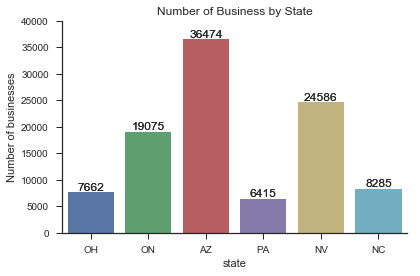

In [8]:
sns.set(style = 'ticks')
ax = sns.countplot(x = 'state',data = d['B'])
plt.rcParams["figure.figsize"] = (10,7)


# plt.xlabel('')
# plt.xticks(np.arange(0, 7), ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of businesses')
plt.title('Number of Business by State')
plt.ylim(0, 40000)
sns.despine()
annot()
plt.legend(loc = 0)
plt.tight_layout()
# plt.savefig('../Plots/State Distribution', dpi = 300, fmt = 'png')  
plt.show()

In [15]:
# Adding week and weekday column
d['R']['year'] = [d['R']['date'][i].year for i in range(len(d['R']))]
d['R']['month'] = [d['R']['date'][i].month for i in range(len(d['R']))]
d['R']['week'] = [d['R']['date'][i].isocalendar()[1] for i in range(len(d['R']))]
d['R']['weekday'] = [d['R']['date'][i].weekday() for i in range(len(d['R']))]

In [16]:
d['R'].head(1)

,text_stem,review_id,business_id,review_cool,date,review_funny,review_stars,review_useful,user_id,polarity,subjectivity,year,month,week,weekday
0,I had a great meal here with friend from flori...,ygWJIyvfqwbmXHx1ucmJvw,_18eAwEHvc6RSa6MeynXag,0.0,2010-02-15,0.0,3.0,0.0,mCtbnY3HVLUmb91ADNPczQ,0.472222,0.45,2010,2,7,0


In [17]:
d['R']['pos'] = np.where(d['R']['review_stars'] >3, 1, 0)

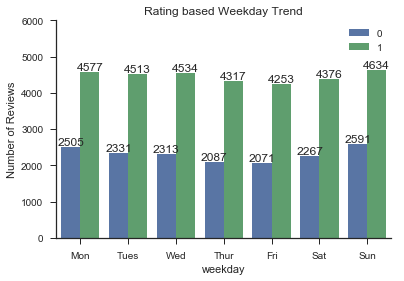

In [18]:
sns.set(style = 'ticks')
ax = sns.countplot(x = 'weekday',hue = 'pos', data = d['R'])

# plt.xlabel('')
plt.xticks(np.arange(0, 7), ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of Reviews')
plt.title('Rating based Weekday Trend')
plt.ylim(0, 6000)
sns.despine()
annot()
plt.legend(loc = 0)
plt.savefig('../Plots/Weekday Trend', dpi = 300, fmt = 'png')  
plt.show()

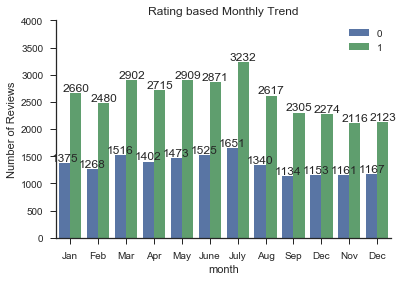

In [19]:
sns.set(style = 'ticks')
ax = sns.countplot(x = 'month',hue = 'pos', data = d['R'])

# plt.xlabel('')
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Dec', 'Nov', 'Dec'])
plt.ylabel('Number of Reviews')
plt.title('Rating based Monthly Trend')
plt.ylim(0, 4000)
sns.despine()
annot()
plt.legend(loc = 0)
plt.savefig('../Plots/Monthly Trend', dpi = 300, fmt = 'png')  
plt.show()

In [224]:
d['R']['date'].describe()

count                 4736897
unique                   4409
top       2017-07-14 00:00:00
freq                     4249
first     2004-07-22 00:00:00
last      2017-07-26 00:00:00
Name: date, dtype: object

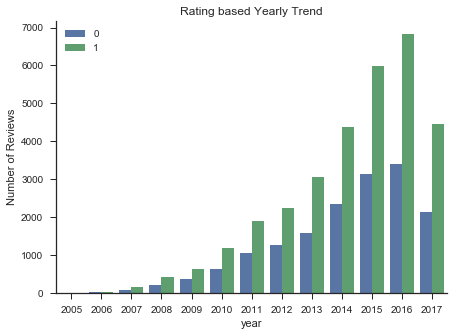

In [20]:
plt.rcParams["figure.figsize"] = (7,5)
ax = sns.countplot(x = 'year',hue = 'pos', data = d['R'])

# plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Dec', 'Nov', 'Dec'])
plt.ylabel('Number of Reviews')
plt.title('Rating based Yearly Trend')
# plt.ylim(0, 4000)
sns.despine()
# annot()
plt.legend(loc = 2)
plt.savefig('../Plots/Yearly Trend', dpi = 300, fmt = 'png')  
plt.show()

In [82]:
d['R']['day'] = [d['R']['date'][i].day for i in range(len(d['R']))]
d['R']['time'] = d['R']['year'] + d['R']['month']/12 + d['R']['day']/360
d['R']['time'].describe()

count    47369.000000
mean      2014.797051
std          2.234290
min       2005.261111
25%       2013.483333
50%       2015.355556
75%       2016.561111
max       2017.655556
Name: time, dtype: float64

## Temporal trends

In [102]:
time_breaks = list(np.arange(min(d['R']['time']), max(d['R']['time']), 1/6))

viz = defaultdict(list)
for i in range(len(time_breaks)-1):
    temp = d['R'][(d['R']['time'] >= time_breaks[i]) & (d['R']['time'] <= time_breaks[i+1])]
    neg = temp[temp['review_stars'] < 3]
    pos = temp[temp['review_stars'] > 3]
    viz['time'].append(time_breaks[i])
    viz['mean_stars'].append(np.mean(temp['review_stars']))
    viz['neg_stars'].append(np.mean(neg['review_stars']))
    viz['pos_stars'].append(np.mean(pos['review_stars']))
viz = pd.DataFrame(viz)
viz = viz.fillna(0)
viz.tail()

,mean_stars,neg_stars,pos_stars,time
69,3.763826,1.306180,4.726919,2016.761111
70,3.741722,1.345946,4.732000,2016.927778
71,3.853687,1.385827,4.762393,2017.094444
72,3.750494,1.330040,4.751111,2017.261111
73,3.784830,1.334821,4.726580,2017.427778


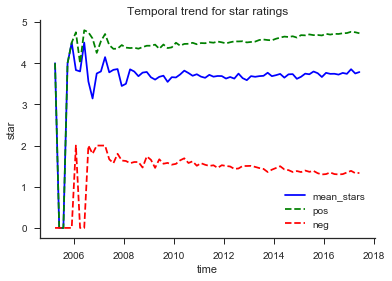

In [108]:
plt.plot(viz['time'], viz['mean_stars'], c = 'b')
plt.plot(viz['time'], viz['pos_stars'], c = 'g', ls = '--', label = 'pos')
plt.plot(viz['time'], viz['neg_stars'], c = 'r', ls = '--', label = 'neg')
plt.xlabel('time')
plt.ylabel('star')
plt.title('Temporal trend for star ratings')
plt.legend()
sns.despine()
# plt.savefig('../Plots/Temporal trends', dpi = 300, fmt = 'png')
plt.show()

In [117]:
# print(list(d['B']))
print(d['R'].shape)
d['R'] = d['R'].merge(d['B'], on = 'business_id', how = 'left')
print(d['R'].shape)

(47369, 18)
(47369, 42)


In [120]:
viz = defaultdict(list)
for i in range(len(time_breaks)-1):
    temp = d['R'][(d['R']['time'] >= time_breaks[i]) & (d['R']['time'] <= time_breaks[i+1])]
    viz['time'].append(time_breaks[i])
    viz['mean_stars'].append(np.mean(temp['review_stars']))
    for state in d['B']['state'].unique():
        this_state = temp[temp['state'] == state]
        viz[state].append(np.mean(this_state['review_stars']))
viz = pd.DataFrame(viz)
viz = viz.fillna(0)
viz.tail()

,AZ,NC,NV,OH,ON,PA,mean_stars,time
69,3.818182,3.836957,3.715074,3.682353,3.557576,3.810345,3.763826,2016.761111
70,3.843267,3.512821,3.674115,3.787879,3.731959,3.871795,3.741722,2016.927778
71,3.876866,3.854167,3.882759,3.759036,3.580645,3.973333,3.853687,2017.094444
72,3.764275,3.927273,3.835843,3.659574,3.454106,3.710526,3.750494,2017.261111
73,3.867893,3.669173,3.809451,3.833333,3.484848,3.775000,3.784830,2017.427778


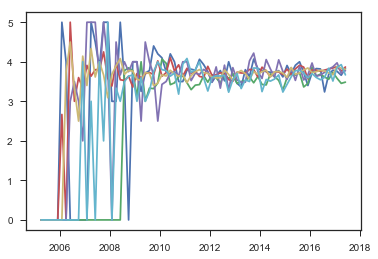

In [121]:
for state in d['B']['state'].unique():
    plt.plot(viz['time'], viz[state])
plt.show()

In [122]:
print(list(d['R']))

['text_stem', 'review_id', 'business_id', 'review_cool', 'date', 'review_funny', 'review_stars', 'review_useful', 'user_id', 'polarity', 'subjectivity', 'week', 'weekday', 'year', 'month', 'pos', 'day', 'time', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'buz_name', 'neighborhood', 'postal_code', 'state', 'price', 'credit_card', 'buz_review_count', 'buz_cool_mean', 'buz_funny_mean', 'buz_useful_mean', 'buz_star_mean', 'buz_star_std', 'buz_polarity_mean', 'buz_polarity_std', 'buz_subjectivity_mean', 'buz_subjectivity_std']


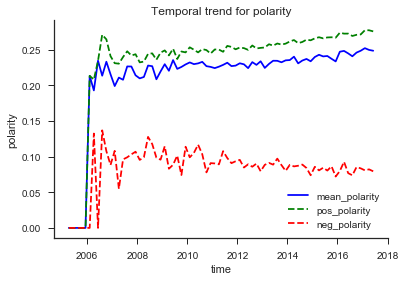

In [127]:
# Look at buz_polarity_mean

viz = defaultdict(list)
for i in range(len(time_breaks)-1):
    temp = d['R'][(d['R']['time'] >= time_breaks[i]) & (d['R']['time'] <= time_breaks[i+1])]
#     median = np.median(d['R']['buz_polarity_mean'])
    neg = temp[temp['buz_polarity_mean'] <= .15]
    pos = temp[temp['buz_polarity_mean'] > .15]
    viz['time'].append(time_breaks[i])
    viz['mean_stars'].append(np.mean(temp['buz_polarity_mean']))
    viz['neg_stars'].append(np.mean(neg['buz_polarity_mean']))
    viz['pos_stars'].append(np.mean(pos['buz_polarity_mean']))
viz = pd.DataFrame(viz)
viz = viz.fillna(0)
viz.tail()

plt.plot(viz['time'], viz['mean_stars'], c = 'b', label = 'mean_polarity')
plt.plot(viz['time'], viz['pos_stars'], c = 'g', ls = '--', label = 'pos_polarity')
plt.plot(viz['time'], viz['neg_stars'], c = 'r', ls = '--', label = 'neg_polarity')
plt.xlabel('time')
plt.ylabel('polarity')
plt.title('Temporal trend for polarity')
plt.legend()
sns.despine()
# plt.savefig('../Plots/Temporal trends for polarity', dpi = 300, fmt = 'png')
plt.show()

(35647, 42)


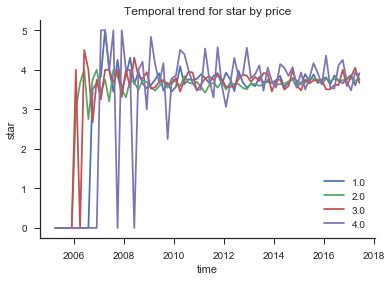

In [138]:
# By price

viz = defaultdict(list)
for i in range(len(time_breaks)-1):
    temp = d['R'][(d['R']['time'] >= time_breaks[i]) & (d['R']['time'] <= time_breaks[i+1])]
    viz['time'].append(time_breaks[i])
    viz['mean_stars'].append(np.mean(temp['review_stars']))
    for state in [1., 2., 3., 4.]:
        this_state = temp[temp['price'] == state]
        viz[state].append(np.mean(this_state['review_stars']))
viz = pd.DataFrame(viz)
viz = viz.fillna(0)
viz.tail()

for state in [1., 2., 3., 4.]:
    plt.plot(viz['time'], viz[state])
plt.xlabel('time')
plt.ylabel('star')
plt.title('Temporal trend for star by price')
plt.legend()
sns.despine()
# plt.savefig('../Plots/Temporal trends for polarity', dpi = 300, fmt = 'png')
plt.show()

In [ ]:
# Define popular as buz_review_count > median(buz_review_count)

# Interactions between mean and medians

In [139]:
print(list(d['R']))

['text_stem', 'review_id', 'business_id', 'review_cool', 'date', 'review_funny', 'review_stars', 'review_useful', 'user_id', 'polarity', 'subjectivity', 'week', 'weekday', 'year', 'month', 'pos', 'day', 'time', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'buz_name', 'neighborhood', 'postal_code', 'state', 'price', 'credit_card', 'buz_review_count', 'buz_cool_mean', 'buz_funny_mean', 'buz_useful_mean', 'buz_star_mean', 'buz_star_std', 'buz_polarity_mean', 'buz_polarity_std', 'buz_subjectivity_mean', 'buz_subjectivity_std']


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


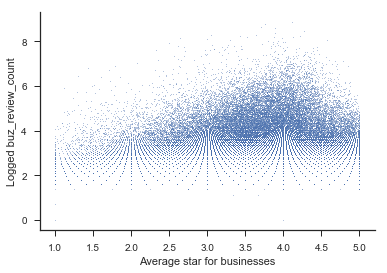

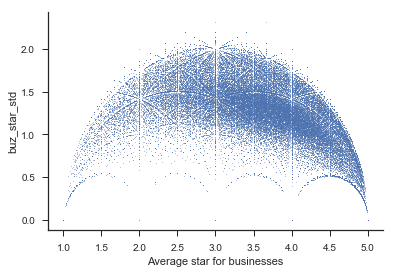

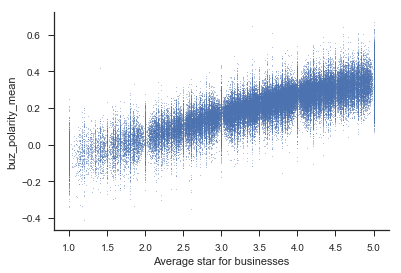

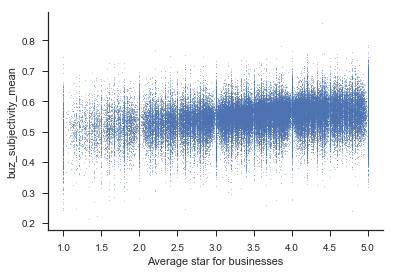

In [170]:
from math import log
interesting_col = ['buz_review_count','buz_star_std', 'buz_polarity_mean', 'buz_subjectivity_mean']
Btemp = d['B'][d['B']['buz_star_mean'] > 0]
temp = Btemp[interesting_col]
for col in interesting_col:
    temp[col] = temp[col].apply(lambda x: 1 if x == 0 else x)

for col in interesting_col:
    if col in ['buz_review_count', 'buz_cool_mean', 'buz_funny_mean', 'buz_useful_mean']:
        y_vals = temp[col].apply(lambda x: log(abs(x)))
        plt.ylabel("Logged " + col)
    else:
        y_vals = Btemp[col]
        plt.ylabel(col)
    plt.scatter(Btemp['buz_star_mean'], y_vals, s = 0.4, alpha = 0.5)
    plt.xlabel('Average star for businesses')
    sns.despine()
#     plt.savefig('buz_'+col, fmt = 'png', dpi = 300)
    plt.show()


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


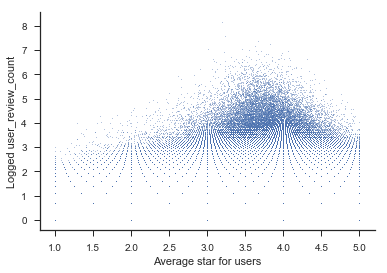

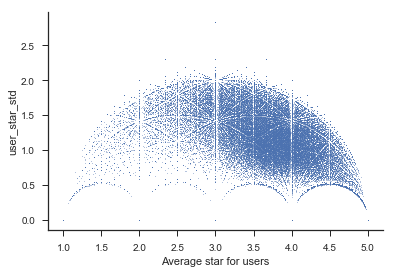

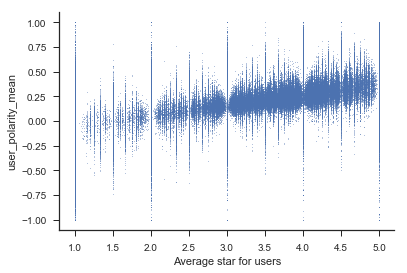

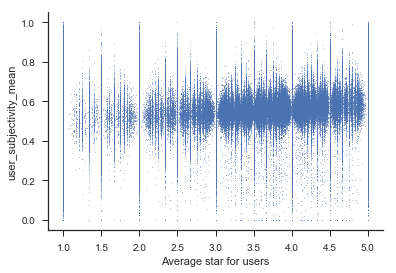

In [174]:
interesting_col = ['user_review_count','user_star_std', 'user_polarity_mean', 'user_subjectivity_mean']
Btemp = d['U'][d['U']['user_star_mean'] > 0]
temp = Btemp[interesting_col]
for col in interesting_col:
    temp[col] = temp[col].apply(lambda x: 1 if x == 0 else x)

for col in interesting_col:
    if col in ['user_review_count']:
        y_vals = temp[col].apply(lambda x: log(abs(x)))
        plt.ylabel("Logged " + col)
    else:
        y_vals = Btemp[col]
        plt.ylabel(col)
    plt.scatter(Btemp['user_star_mean'], y_vals, s = .4, alpha = 0.5)
    plt.xlabel('Average star for users')
    sns.despine()
#     plt.savefig('user_'+col, fmt = 'png', dpi = 300)
    plt.show()

# Now look at the Useful, Cool and Funny

In [178]:
def show():
    sns.despine()
    plt.show()

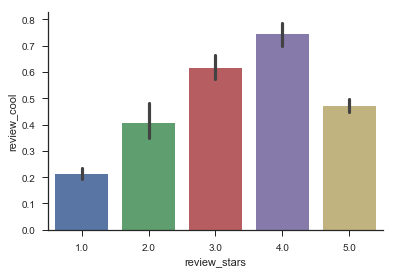

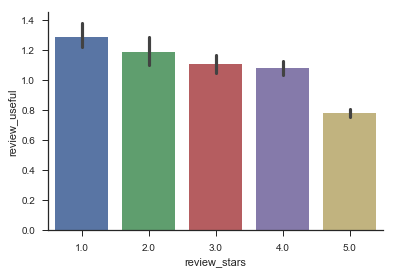

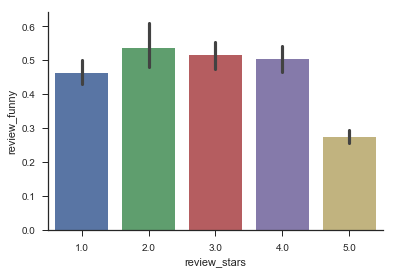

In [182]:
for col in ['review_cool', 'review_useful', 'review_funny']:
    sns.barplot(data = d['R'], y = col, x = 'review_stars')
    sns.despine()
#     plt.savefig(col+' average star', dpi = 300, fmt = 'png')
    plt.show()

In [187]:
d['I'] = pd.read_csv(parent_dir + 'review_info.csv')
d['R'] = pd.read_csv(parent_dir + 'review_text.csv')

d['R'] = d['R'].merge(d['I'], on = 'review_id', how = 'inner')

In [195]:
d['R']['review_useful'].describe()

count    4.736895e+06
mean     9.882925e-01
std      2.600022e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.125000e+03
Name: review_useful, dtype: float64

In [204]:
d['R']['q_review_useful'] = (pd.cut(np.array(d['R']['review_useful']), bins = 100, labels=False) +1 ) * 1
d['R']['q_review_cool'] = (pd.cut(np.array(d['R']['review_cool']), bins = 100, labels=False) +1 ) * 1
d['R']['q_review_funny'] = (pd.cut(np.array(d['R']['review_funny']), bins = 100, labels=False) +1 ) * 1

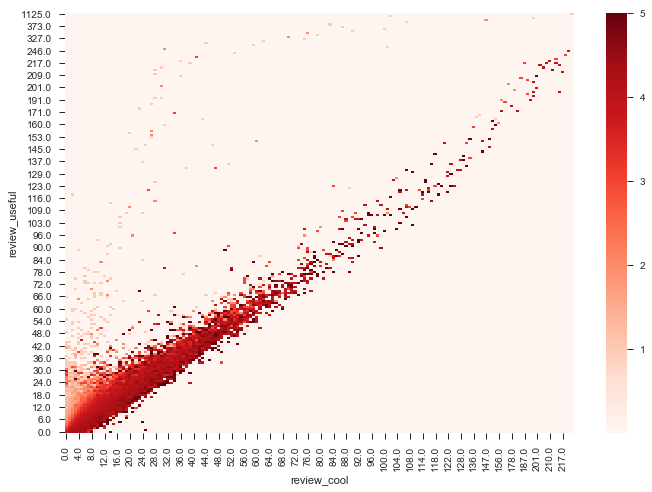

In [230]:
plt.rcParams["figure.figsize"] = (10,7)

heat = d['R'].pivot_table("review_stars", "review_useful", "review_cool").fillna(0.0001)
ax = sns.heatmap(heat, cmap="Reds")
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('../Plots/heat_useful_cool', dpi = 300, fmt = 'png')
plt.show()

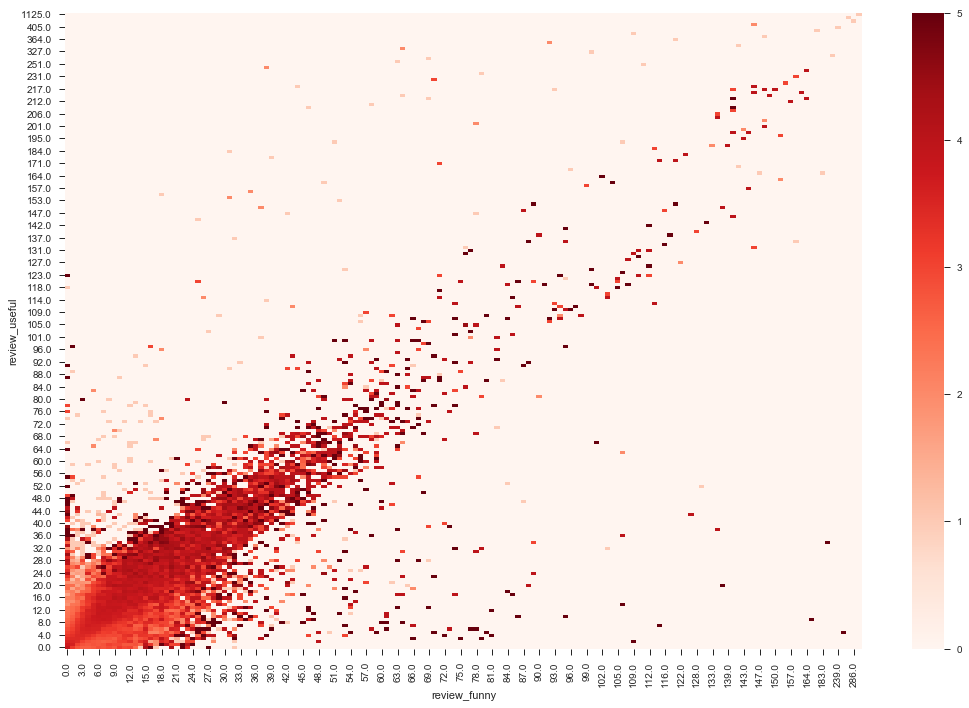

In [214]:
heat = d['R'].pivot_table("review_stars", "review_useful", "review_funny").fillna(0)
ax = sns.heatmap(heat, cmap="Reds")
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('../Plots/heat_useful_funny', dpi = 300, fmt = 'png')
plt.show()

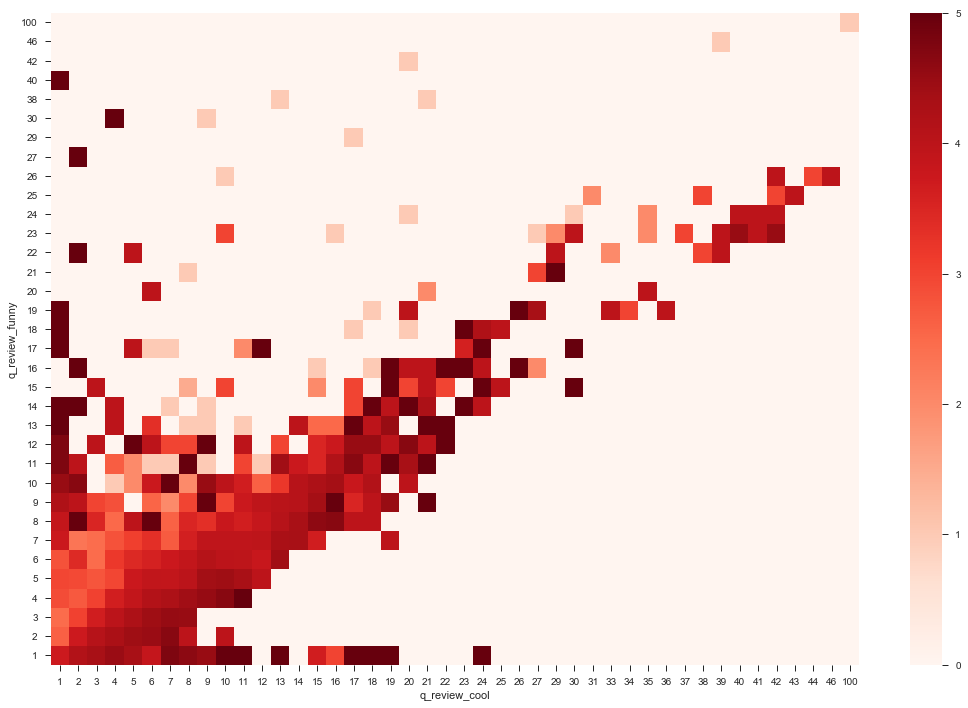

In [217]:
heat = d['R'].pivot_table("review_stars", "q_review_funny", "q_review_cool").fillna(0)
ax = sns.heatmap(heat, cmap="Reds")
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('../Plots/heat_q_funny_cool', dpi = 300, fmt = 'png')
plt.show()

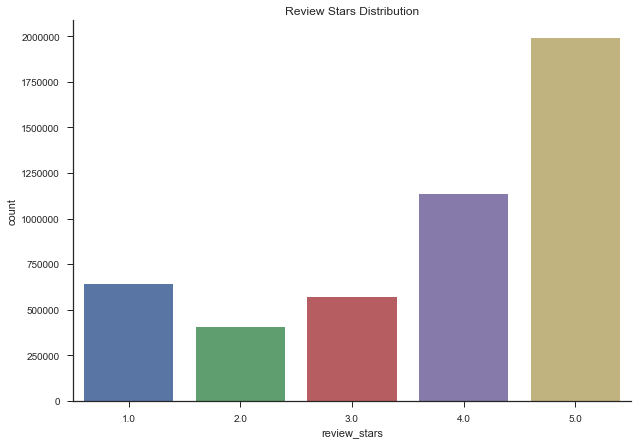

In [232]:
sns.countplot(d['R']['review_stars'])
sns.despine()
plt.title("Review Stars Distribution")
# plt.savefig('../Plots/Review Stars Distribution', dpi = 300, fmt = 'png')
plt.show()